First, we will load the relevant libraries and functions. Since we will be comparing ensemble models to our own ensemble and also to a basseline model, we will import the following models: Random Forest, AdaBoost, BaggingClassifier, VotingClassifier. We will compare these to the performance of a Logistic Regression and KNN model. We will also use the Decision Tree model to build our own ensemble.

In [5]:
# import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
# read the Titanic data set from seaborn
data = sns.load_dataset('titanic')

In [4]:
data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


Now we will clean the data. Since we are familiar with this data set already, we know what to do: drop columns [deck, class, who, adult_male, embark_town, alive, alone]. Fill in missing values for Age, based on sex. Create a new feature to calculate total family size, and convert all categories to dummies. Let's begin: 

In [8]:
# drop columns
df = data.drop(['deck','class','who','adult_male','embark_town','alive','alone'], axis=1)

In [9]:
# fill in missing values for Age
df['age'] = df['age'].fillna(df.groupby('sex')['age'].transform('mean'))

In [10]:
# add total family size
df['fam'] = df['parch'] + df['sibsp']

In [12]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,fam
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,1
2,1,3,female,26.0,0,0,7.9250,S,0
3,1,1,female,35.0,1,0,53.1000,S,1
4,0,3,male,35.0,0,0,8.0500,S,0


In [18]:
# create dummies
dummies = pd.get_dummies(df[['sex','embarked']], dtype=int)

In [19]:
dummies

,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,0,1,0,0,1
1,1,0,1,0,0
2,1,0,0,0,1
3,1,0,0,0,1
4,0,1,0,0,1
...,...,...,...,...,...
886,0,1,0,0,1
887,1,0,0,0,1
888,1,0,0,0,1
889,0,1,1,0,0


In [20]:
# combine final data set
df_fin = pd.concat([df[['survived','pclass','fare','fam']], dummies], axis=1)

In [22]:
df_fin.head()

,survived,pclass,fare,fam,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,0,3,7.2500,1,0,1,0,0,1
1,1,1,71.2833,1,1,0,1,0,0
2,1,3,7.9250,0,1,0,0,0,1
3,1,1,53.1000,1,1,0,0,0,1
4,0,3,8.0500,0,0,1,0,0,1


In [28]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   pclass      891 non-null    int64  
 2   fare        891 non-null    float64
 3   fam         891 non-null    int64  
 4   sex_male    891 non-null    int64  
 5   embarked_C  891 non-null    int64  
 6   embarked_Q  891 non-null    int64  
 7   embarked_S  891 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 55.8 KB


In [24]:
# drop redundant columns
df_fin = df_fin.drop(['sex_female'], axis=1)

Now that the data is ready, we can begin comparing models. First we will split data into training and testing, then Standardize using the StandardScaler.

In [25]:
# split data

X = df_fin[['pclass','fare','fam','sex_male', 'embarked_C','embarked_Q','embarked_S']]
y = df_fin['survived']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [37]:
# build a baseline model - Logistic Regression
log = LogisticRegression()
log.fit(X_train, y_train)
pred = log.predict(X_test)
print("accuracy: ", accuracy_score(pred,y_test))
print('F1_score: ', f1_score(pred,y_test))
print('precision: ', precision_score(pred,y_test))
print('recall: ', recall_score(pred, y_test))

accuracy:  0.7821229050279329
F1_score:  0.738255033557047
precision:  0.7432432432432432
recall:  0.7333333333333333


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
# build a baseline KNN model
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
pred2 = knn.predict(X_test)
print("accuracy: ", accuracy_score(pred2,y_test))
print('F1_score: ', f1_score(pred2,y_test))
print('precision: ', precision_score(pred2,y_test))
print('recall: ', recall_score(pred2, y_test))

accuracy:  0.7374301675977654
F1_score:  0.6666666666666666
precision:  0.6351351351351351
recall:  0.7014925373134329


So far, the logistic regresssion seems to work okay. Let's build an ensemble model.

In [52]:
y_train.reset_index().drop('index', axis=1)

,survived
0,0
1,0
2,1
3,0
4,1
...,...
707,1
708,0
709,0
710,0


In [53]:
# let's use the bootstrap function from the notes

def bootstrap_sample(X_train, y_train):
    indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    return X_train.reset_index().drop('index', axis=1)[indices], y_train.reset_index().drop('index', axis=1)[indices]

In [54]:
# Train multiple decision trees on different bootstrap samples
n_trees = 50
trees = []

for _ in range(n_trees):
    X_sample, y_sample = bootstrap_sample(X_train, y_train)
    
    # Clone the pipeline for each tree
    tree = DecisionTreeClassifier(max_depth=30) # set max depth so trees don't run forever
    tree.fit(X_sample, y_sample)
    trees.append(tree)

KeyError: "None of [Index([664, 186, 705, 478, 431, 633, 312, 553, 507, 676,\n       ...\n       422, 708, 586, 442, 491, 630, 685, 417,  94, 354],\n      dtype='int64', length=712)] are in the [columns]"

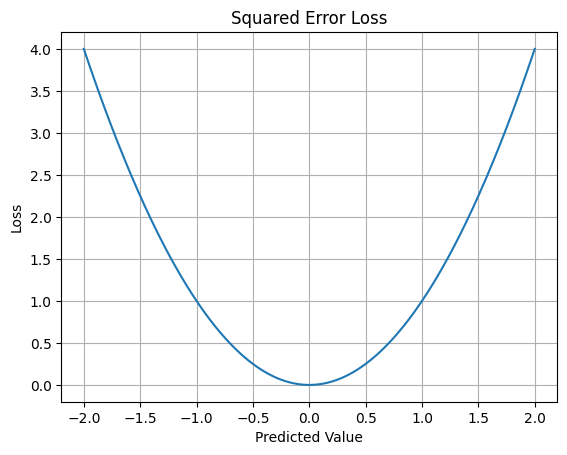

In [55]:
import numpy as np
import matplotlib.pyplot as plt

y_pred = np.linspace(-2, 2, 400)
y_true = 0
loss = (y_pred - y_true) ** 2

plt.plot(y_pred, loss)
plt.title('Squared Error Loss')
plt.xlabel('Predicted Value')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


/var/folders/75/tr_v06ms4k7gy38vcppxbcf80000gn/T/ipykernel_58011/126811502.py:14: RuntimeWarning: invalid value encountered in log
  log_loss = -y_true * np.log(y_pred + epsilon) - (1 - y_true) * np.log(1 - y_pred + epsilon)


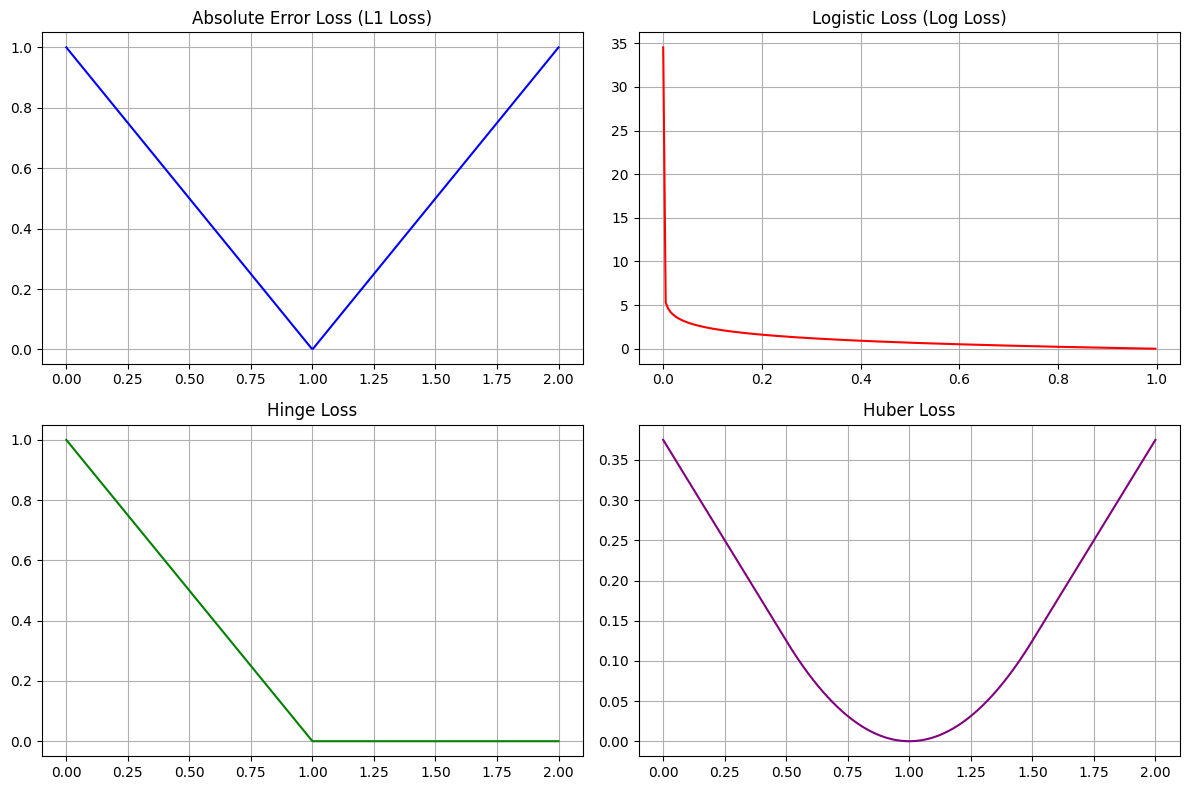

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Define a range of predicted values
y_pred = np.linspace(0, 2, 400)
y_true = 1

# 1. Absolute Error Loss (L1 Loss)
l1_loss = np.abs(y_pred - y_true)

# 2. Logistic Loss (Log Loss)
# Small constant to avoid log(0) error
epsilon = 1e-15
log_loss = -y_true * np.log(y_pred + epsilon) - (1 - y_true) * np.log(1 - y_pred + epsilon)

# 3. Hinge Loss
hinge_loss = np.maximum(0, 1 - y_true * y_pred)

# 4. Huber Loss
delta = 0.5
huber_loss = np.where(np.abs(y_pred - y_true) <= delta, 0.5 * (y_pred - y_true)**2, delta * np.abs(y_pred - y_true) - 0.5 * delta**2)

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(y_pred, l1_loss, label="L1 Loss", color="blue")
plt.title('Absolute Error Loss (L1 Loss)')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(y_pred, log_loss, label="Logistic Loss", color="red")
plt.title('Logistic Loss (Log Loss)')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(y_pred, hinge_loss, label="Hinge Loss", color="green")
plt.title('Hinge Loss')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(y_pred, huber_loss, label="Huber Loss", color="purple")
plt.title('Huber Loss')
plt.grid(True)

plt.tight_layout()
plt.show()
